# Results and Discussion

This notebook describes how we perform hyperparameter search based on training results and how to interpret predictions given by the best model.

In [108]:
# initialise the workspace
workdir = "C:/Users/XTM23/Documents/@PARA/y2023/309-UROP/test-antiberta" # when relative path fails

## Setup of all the things we need

In [109]:
# Some imports 
from transformers import (
    RobertaConfig,
    RobertaTokenizer,
    RobertaForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset
import os
import torch
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import csv

# Initialise the tokeniser
tokenizer = RobertaTokenizer.from_pretrained("antibody-tokenizer")

In [110]:
# TODO include these functions in utils, commented
# transform json files into dataframe

def read_log(filepath):
    """
    Arg:
        filepath a string representing path of .json file
    """
    js = pd.read_json(filepath)
    s = js["best_model_checkpoint"][0] # the directory of best checkpoint
    best_model_checkpoint = int(s.split("-")[-1]) # the number of steps at which the best metric is obtained
    lst = filepath.split("checkpoint-")
    lst = lst[1].split("/")
    total_steps = int(lst[0])
    df = pd.json_normalize(js["log_history"])
    n = len(df)
    # dataframe contianing eval loss
    odd_indx = np.array([i for i in range(n) if i%2 == 1])
    df1 = df.loc[odd_indx,:]
    # dataframe contianing train loss
    even_indx = np.array([i for i in range(n) if i%2 == 0])
    df2 = df.loc[even_indx,:]
    # if use_epoch:
    #     df1 = df1[["epoch", "eval_loss"]]
    #     df2 = df2[["epoch", "loss"]]
    #     df3 = df1.join(df2.set_index('epoch'), on='epoch')
    # else:
    df1 = df1[["step", "eval_loss"]]
    df2 = df2[["step", "loss"]]
    df3 = df1.join(df2.set_index('step'), on='step')
    return df3,js["best_metric"][0],best_model_checkpoint, total_steps

def generate_path(i, j, k):
    # return path of the latest checkpoint json file for specified model
    s = "-".join(["train",str(i),str(j),str(k)])
    lst = os.listdir("output/finished/"+s+"/test")
    cps = []
    for d in lst:
        i = int(d.split("-")[-1])
        cps.append(i)
    cps.sort()
    path = "/".join(["output/finished",s,f"test/checkpoint-{cps[-1]}","trainer_state.json"])
    return path

def save_log(filepath, directory): # TODO move this to training_helper
    import os
    import csv
    from utils.training_helper import read_log, find_best_checkpoint
    """
    filepath: string, path of the output csv file
    directory: string, path of parent directories of all models
    """
    # list all immediate subfolders of the working directory
    lst = os.listdir(path=directory)
    log = []
    for d in lst:
        if d.startswith('train-'):
            if len(os.listdir(d)) !=0:
                if len(os.listdir(d+"/model")) != 0:
                    # if best model is saved, meaning training has been finished
                    [n_head, n_layer, rand_ind] = d.split("-")[1:]
                    _,best_metric,best_model_checkpoint, total_steps = read_log(find_best_checkpoint(d))
                    log.append([n_head, n_layer, rand_ind, best_metric, best_model_checkpoint, total_steps])

    with open('output/log.csv', 'w', newline='') as file:
        # by default, it overwrites everything
        writer = csv.writer(file)
        writer.writerow(["n_head", "n_layer", "rand_ind", "best_metric", "best_model_checkpoint", "total_steps"])
        for line in log:
            writer.writerow(line)
    
    return pd.read_csv(filepath)

In [111]:
# TODO unify the method of extracting logs
# put all the logs into respective dataframe
log_dic = {}
for i in range(1,5):
    # n_head
    for j in range(1,5):
        # n_layer
        for k in range(10):
            df, best_metric, best_model_checkpoint, total_steps = read_log(generate_path(i,j,k))
            sub_dic = {"df": df, "best_metric":best_metric,"best_model_cp_step":best_model_checkpoint,"total_steps":total_steps}
            log_dic[(i,j,k)] = sub_dic
# move models into one
# rename 

In [112]:
# create array for hyperparameter search that stores best result for each model
df_hs = np.zeros((4,4,10)) 
for i in range(4):
    for j in range(4):
        for k in range(10):
            df_hs[i,j,k] = log_dic[(i+1,j+1,k)]["best_metric"]
# get average of each set of hyperparameters over different ways of splitting datasets
mat_hs = np.mean(df_hs, axis=2)


In [113]:
df = pd.DataFrame(mat_hs, columns = ['1 layer','2 layers','3 layers', "4 layers"], index = ['1 head', '2 heads', "3 heads", "4 heads"])

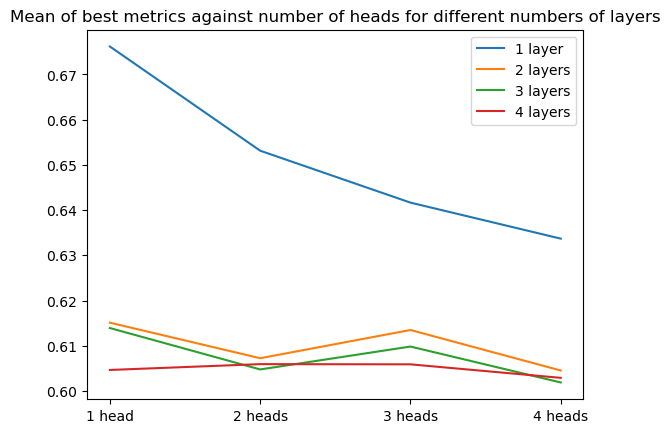

In [114]:
plt.plot(df, label=['1 layer','2 layers','3 layers', "4 layers"])
plt.title("Mean of best metrics against number of heads for different numbers of layers")
plt.legend()
plt.show()

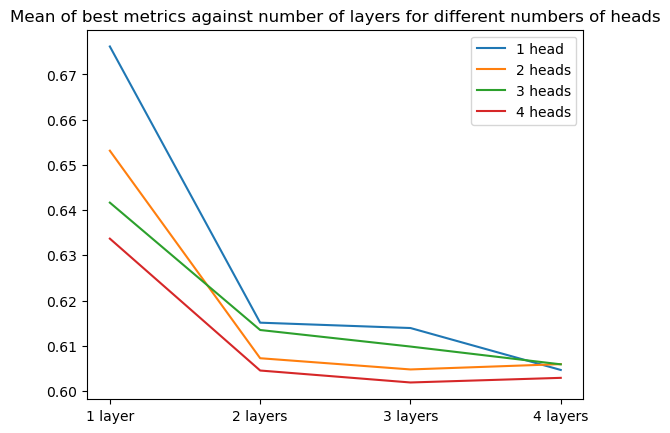

In [115]:
df = pd.DataFrame(mat_hs.transpose(), index = ['1 layer','2 layers','3 layers', "4 layers"], columns = ['1 head', '2 heads', "3 heads", "4 heads"])
plt.plot(df, label=['1 head', '2 heads', "3 heads", "4 heads"])
plt.title("Mean of best metrics against number of layers for different numbers of heads")
plt.legend()
plt.show()

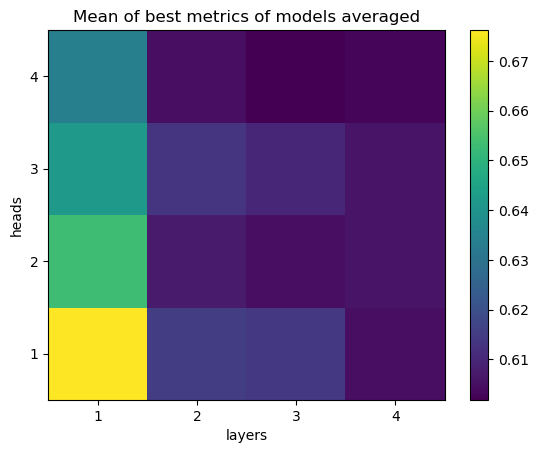

In [116]:
fig, ax= plt.subplots()
ticks = [1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis')
ax.set_xlabel("layers")
ax.set_ylabel("heads")
ax.set_title("Mean of best metrics of models averaged")
fig.colorbar(c, ax=ax)
plt.show()

In [117]:
def list2txt(lst,filepath, overwrite=True): # TODO change to import
    """
    save content of a list into text file
    Args:
        lst: a list of tuples
        filepath: a string indicating the path of a text file
    """
    # clear file content before writing
    if not overwrite:
        with open(filepath, 'a') as f:
            for line in lst:
                f.write(str(line)+"\n")
    else:
        with open(filepath, 'w') as f:
            for line in lst:
                f.write(str(line)+"\n")

Given the trend observed, we expect models with more layers or more heads would perform better. Therefore, we expand the range of hyperparameters gradually.

In [118]:
train_array = []
# add more sets of parameters
for s in ["6-2","6-3","6-4","6-5", "4-5","3-5","2-5","1-5", "6-1"]:
    i, j = tuple(s.split("-"))
    for k in range(5):
        train_array.append((int(i),int(j),k))
for s in ["6-2","6-3","6-4","6-5", "4-5","3-5","2-5","1-5", "6-1"]:
    i, j = tuple(s.split("-"))
    for k in range(5,10):
        train_array.append((int(i),int(j),k))
for s in ["6-6","5-6","4-6","3-6","2-6","1-6","8-1","8-2","8-3","8-4","8-5","8-6"]:
    i, j = tuple(s.split("-"))
    for k in range(10):
        train_array.append((int(i),int(j),k))
list2txt(train_array,"output/training_plan.txt")

## Check specific models

In [119]:
def write2file(st, name):
    with open("./assets/"+name+'.txt', 'w') as f:
        for line in st:
            f.write(line+"\n")

def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    with open(filename,'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
            else:
                current_seq+=line[:-1]
                count+=1
        all_seqs.append(current_seq)
        #all_seqs=np.array(map(lambda x: [aadict[y] for y in x],all_seqs[1:]),dtype=int,order="c")
    return all_seqs

name_fasta='input/sabdab_heavy.txt'
seqs_al  =load_FASTA(name_fasta)[1:]

# remove gaps in seqs_al
seqs=[]
for s in range(len(seqs_al)):
    seqs.append(''.join([seqs_al[s][i] for i in range(len(seqs_al[s])) if seqs_al[s][i]!='-']))
# sanity check through site 97 TODO
def extract_prob(model):
    """
    return normalised probability predcted by the model
    """
    # TODO produce seq_al, final_indices
    probs = []
    N = len(seqs_al)
    final_indices = range(N)
    # TODO make this final_indices, consist with that of random split
    for s in final_indices:
    #for s in range(1,2):
        # for a given seq, convert each symbol to a number (position along the alphabet)
        # and add a begind/end symbol
        # token_ids = tokenizer.encode(seqs[s], return_tensors='pt')
        token_ids = tokenizer.encode(seqs_al[s], return_tensors='pt') # to maintain a homogeneous shape
        #train
        # take the model and calculate the MaskedLMOutput, take its logits
        # which are in a matrix with size # tokens x # symbols 
        ## (note: it's a single-sequence embedding)
        out = model(token_ids)
        mat = out['logits'].squeeze()
        
        ## calculate attention of each token, which is a probability conditional on the rest of the sequence
        ## to obtain a probability, one normalizes over the column (possible symbols at that position)
        ## and flatten everything into a vector of length # tokens x # symbols
        prob = torch.nn.functional.softmax(mat, dim=1).detach().numpy()
        probs.append(prob)
        # add progress indicator
        if s%100 == 0:
            print(f"{(s+1)/len(final_indices)} done")
    return probs
    
def prob_at_site(index, probs):
    # index: integer, position at aligned sequences
    # return: an array of Nx25
    n_seq = len(probs)
    output = np.zeros((n_seq,25))
    for i in range(n_seq):
        output[i,:] = probs[i][index,:]
    return output

In [120]:
# TODO run this cell on HPC
prob_dict = {}
for d in os.listdir("./backup_model/"):
    model_dir = "./backup_model/"+d
    model_set = d.split("-")
    n_layer = int(model_set[0])
    n_head = int(model_set[1])
    rand_ind = int(model_set[2])
    model = RobertaForMaskedLM.from_pretrained(model_dir)
    probs = extract_prob(model=model)
    prob_dict[(n_head,n_layer,rand_ind)] = probs

0.0003178639542275906 done
0.032104259376986646 done
0.0638906547997457 done
0.09567705022250476 done
0.12746344564526382 done
0.1592498410680229 done
0.19103623649078194 done
0.222822631913541 done
0.2546090273363001 done
0.2863954227590591 done
0.3181818181818182 done
0.34996821360457725 done
0.3817546090273363 done
0.41354100445009534 done
0.4453273998728544 done
0.4771137952956135 done
0.5089001907183726 done
0.5406865861411316 done
0.5724729815638907 done
0.6042593769866497 done
0.6360457724094087 done
0.6678321678321678 done
0.6996185632549269 done
0.731404958677686 done
0.763191354100445 done
0.7949777495232041 done
0.8267641449459632 done
0.8585505403687221 done
0.8903369357914812 done
0.9221233312142403 done
0.9539097266369994 done
0.9856961220597584 done
0.0003178639542275906 done
0.032104259376986646 done
0.0638906547997457 done
0.09567705022250476 done
0.12746344564526382 done
0.1592498410680229 done
0.19103623649078194 done
0.222822631913541 done
0.2546090273363001 done
0.

In [121]:
import pickle
with open('probs_160.pkl', 'wb') as file:     
    # A new file will be created
    pickle.dump(prob_dict, file)

In [122]:
for i,key in enumerate(prob_dict):
    print(key)

(1, 2, 0)
(1, 2, 8)
(2, 2, 0)
(2, 2, 7)
(2, 2, 8)
(2, 2, 9)
(3, 2, 0)
(4, 2, 0)
(4, 2, 2)
(4, 2, 4)
(4, 2, 7)
(4, 2, 9)
(1, 3, 1)
(1, 3, 9)
(3, 3, 4)
(1, 4, 0)
(1, 4, 4)
(1, 4, 8)
(2, 4, 0)
(2, 4, 8)
(3, 4, 4)
(4, 4, 0)
(4, 4, 4)


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.144e+03]),
 array([5.        , 5.04166667, 5.08333333, 5.125     , 5.16666667,
        5.20833333, 5.25      , 5.29166667, 5.33333333, 5.375     ,
        5.41666667, 5.45833333, 5.5       , 5.54166667, 5.58333333,
        5.625     , 5.66666667, 5.70833333, 5.75      , 5.79166667,
        5.83333333, 5.875     , 5.91666667, 5.95833333, 6.        ]),
 <BarContainer object of 24 artists>)

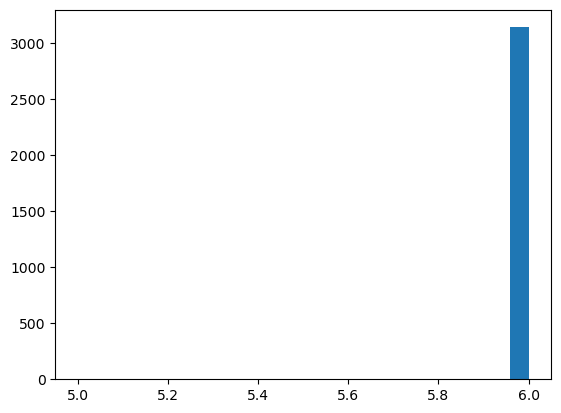

In [123]:
output = prob_at_site(97, probs=prob_dict[(1,2,0)])
output = np.argmax(output, axis=1)
plt.hist(output, bins=24)
# TODO try to plot multiple histograms in one graph

### Compare actual site frequencies to predicted probabilitie

In [124]:
# Compare actual site frequencies to predicted probabilities over all sequencies for one model

# build a tokenized array of all sequences/N
N = len(seqs_al)
seqs_arr = np.zeros((N,128),dtype=int)
for i in range(N):
    token_ids = tokenizer.encode(seqs_al[i], return_tensors='pt')
    seqs_arr[i,:] = token_ids[0,1:-1]
site_freq = np.zeros((128, 25))
for site in range(128):
    tokens, counts = np.unique(seqs_arr[:,site], return_counts=True)
    for i in range(len(tokens)):
        token = tokens[i]
        site_freq[site,token] = counts[i]/N

In [125]:
probs=prob_dict[(3, 3, 4)]
probs = np.array(probs)
pred_prob_ave = np.mean(probs, axis=0)[1:-1,:]

In [126]:
x_arr = np.reshape(site_freq,-1)
y_arr = np.reshape(pred_prob_ave,-1)

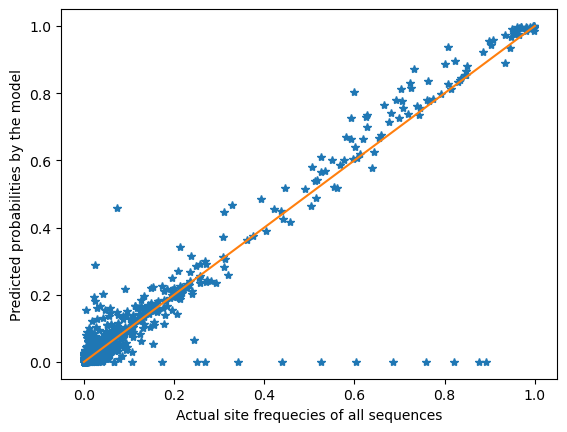

In [127]:
plt.plot(x_arr,y_arr,"*")
plt.xlabel("Actual site frequecies of all sequences")
plt.ylabel("Predicted probabilities by the model")
plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.show()

## Select best models

In [128]:
import pandas as pd
df1 = pd.read_csv("log.csv")
df2 = pd.read_csv("test_output.csv")
merged_df = pd.merge(df1,df2)

In [129]:
merged_df.sort_values("test_loss")

,n_head,n_layer,rand_ind,best_metric,best_model_checkpoint,total_steps,test_loss
289,2,4,1,0.623928,1950,2450,0.558665
188,4,6,1,0.589843,1700,2200,0.573911
359,4,6,5,0.596256,1950,2450,0.574349
4,4,5,5,0.576514,2050,2550,0.575268
325,3,6,1,0.593192,1700,2200,0.577871
...,...,...,...,...,...,...,...
332,6,3,8,0.665243,850,1350,NaN
337,6,3,3,0.607798,1450,1950,NaN
341,6,6,7,0.548551,1800,2300,NaN
348,8,6,6,0.592026,1500,2000,NaN


In [130]:
keys_df = merged_df[['n_head','n_layer']].drop_duplicates()

In [131]:
result = merged_df.groupby(['n_head','n_layer']).aggregate({'best_metric':'mean','test_loss':['count','mean']}).reset_index()
result = result.droplevel(0, axis=1) 
result.columns = ["n_head", "n_layer", "mean_eval_loss", "count", "mean_test_loss"]

In [132]:
result.sort_values("mean_test_loss") # TODO take sd into account

,n_head,n_layer,mean_eval_loss,count,mean_test_loss
31,8,2,0.598632,6,0.603719
23,4,6,0.595892,10,0.605256
17,3,6,0.594953,10,0.605431
22,4,5,0.595440,10,0.606221
21,4,4,0.602915,10,0.607586
11,2,6,0.600187,10,0.608223
5,1,6,0.597531,10,0.609785
10,2,5,0.601494,10,0.610316
16,3,5,0.599952,10,0.613365
9,2,4,0.605948,10,0.614270


We found that the model with 4 heads and 6 layers perform consistently better than other models both in terms of the mean test loss and evaluation loss. Meanwhile, the improvement by increasing from 5 layers to 6 layers is slim. We cease to search over a extended hyperparameter space though the optimal is at the edge.

## Compare the best MLM with RBM

We now compare the predictions given by the best MLM with 4 heads and 6 layers to that from RBM.

## How randomisation of data splits affect performance of models 

In [133]:
def imshow_single_dataset(i):
    mat_hs = df_hs[:,:,i]
    fig, ax= plt.subplots()
    ticks = [1,2,3,4]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis')
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    ax.set_title(f"Mean of best metrics of models on the dataset {i}")
    fig.colorbar(c, ax=ax)

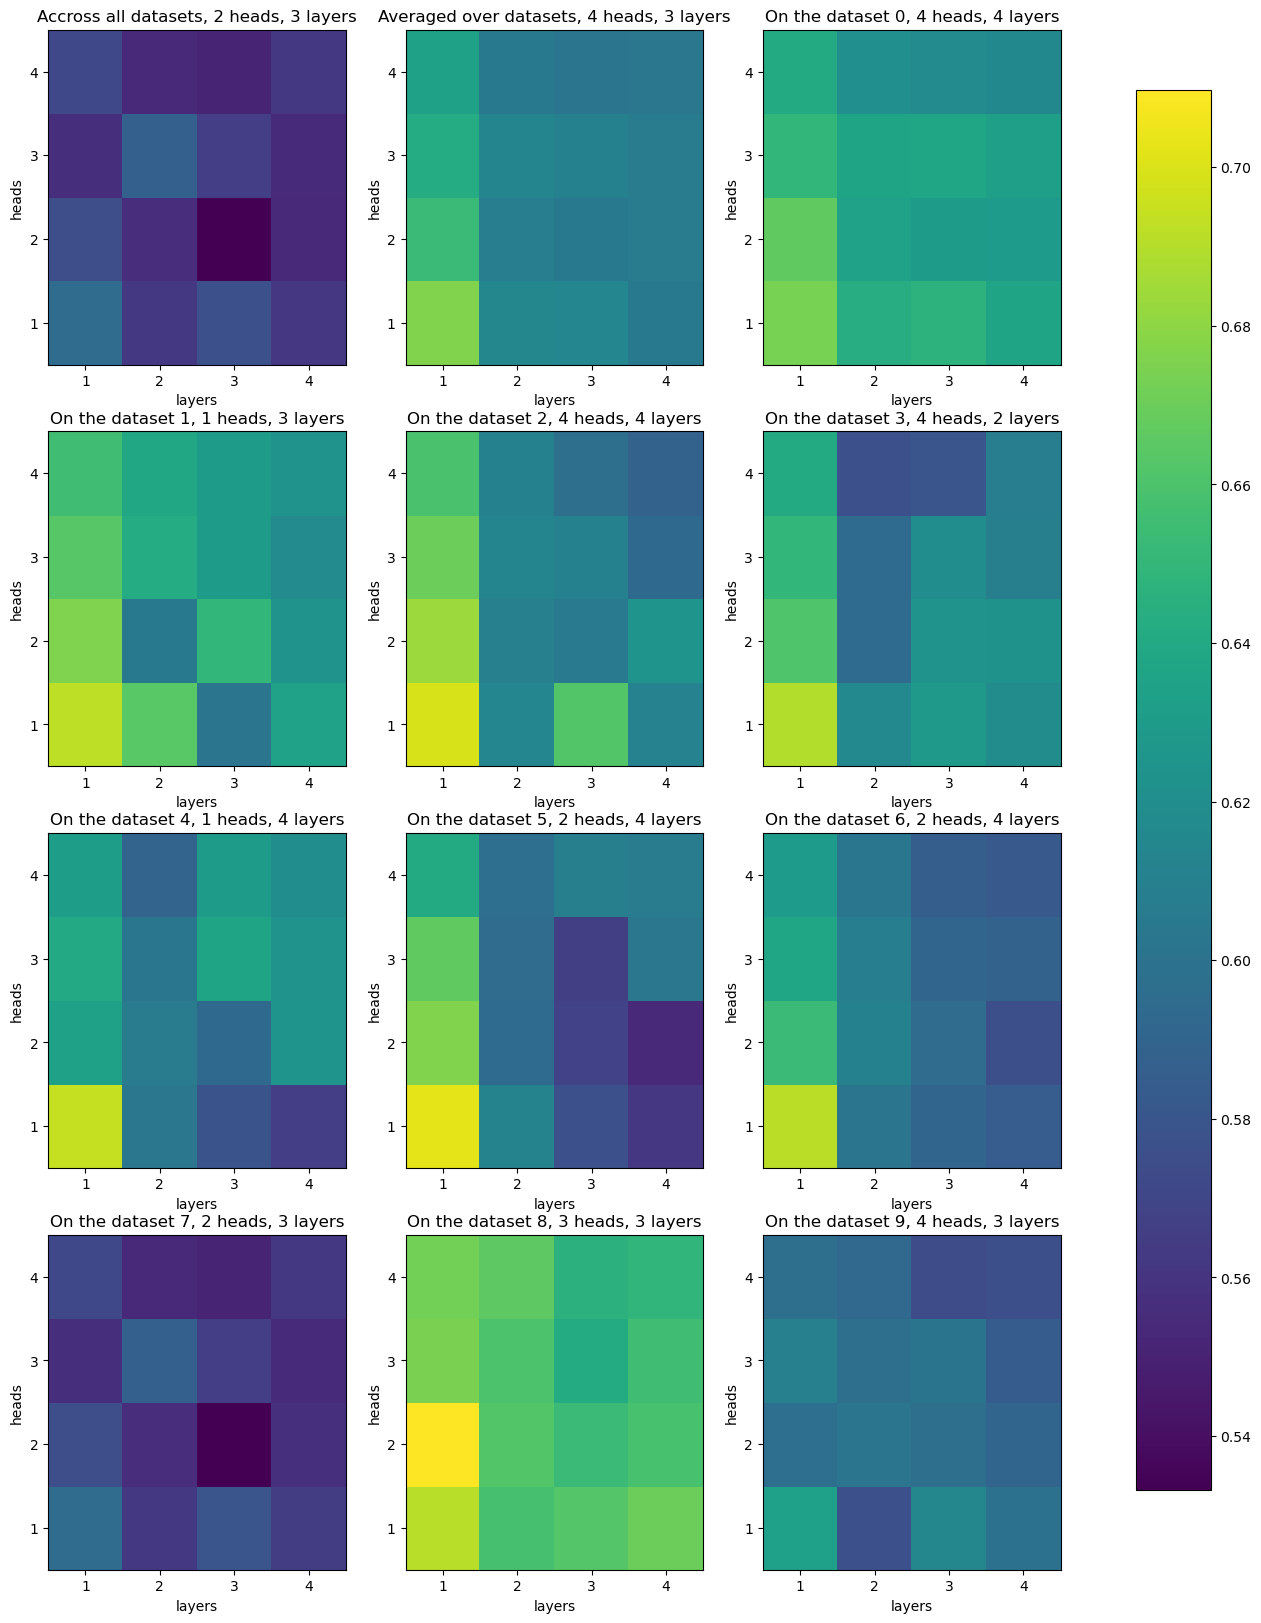

In [134]:
fig, axes = plt.subplots(4,3)
fig.set_figheight(20)
fig.set_figwidth(15)
head_ticks = [1,2,3,4]
layer_ticks = [1,2,3,4]
for i in range(12):
    ax = axes[i//3, i%3]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    if i == 0:
        mat_hs = np.min(df_hs, axis=2)
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"Accross all datasets, {j+1} heads, {k+1} layers")
    elif i == 1:
        mat_hs = np.mean(df_hs, axis=2)
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"Averaged over datasets, {j+1} heads, {k+1} layers")     
    else:
        mat_hs = df_hs[:,:,i-2]
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"On the dataset {i-2}, {j+1} heads, {k+1} layers")
    c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis', vmin=np.min(df_hs), vmax=np.max(df_hs))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(c, ax=ax)
fig.colorbar(c, cax=cbar_ax)
plt.show()

#TODO add error bar for different datasets


### How randomisation of data splits affect training speed of models

Consider models with the same number of heads and number of layers, we compare number of steps required for them to converge when trained with different splits of datasets. Note the random initialisation of parameters is not controlled.

In [135]:
# create array for hyperparameter search that stores best result for each model
df_speed = np.zeros((4,4,10)) 
for i in range(4):
    for j in range(4):
        for k in range(10):
            df_speed[i,j,k] = log_dic[(i+1,j+1,k)]["best_model_cp_step"]
# get average of each set of hyperparameters over different ways of splitting datasets
# mat_hs = np.mean(df_hs, axis=2)

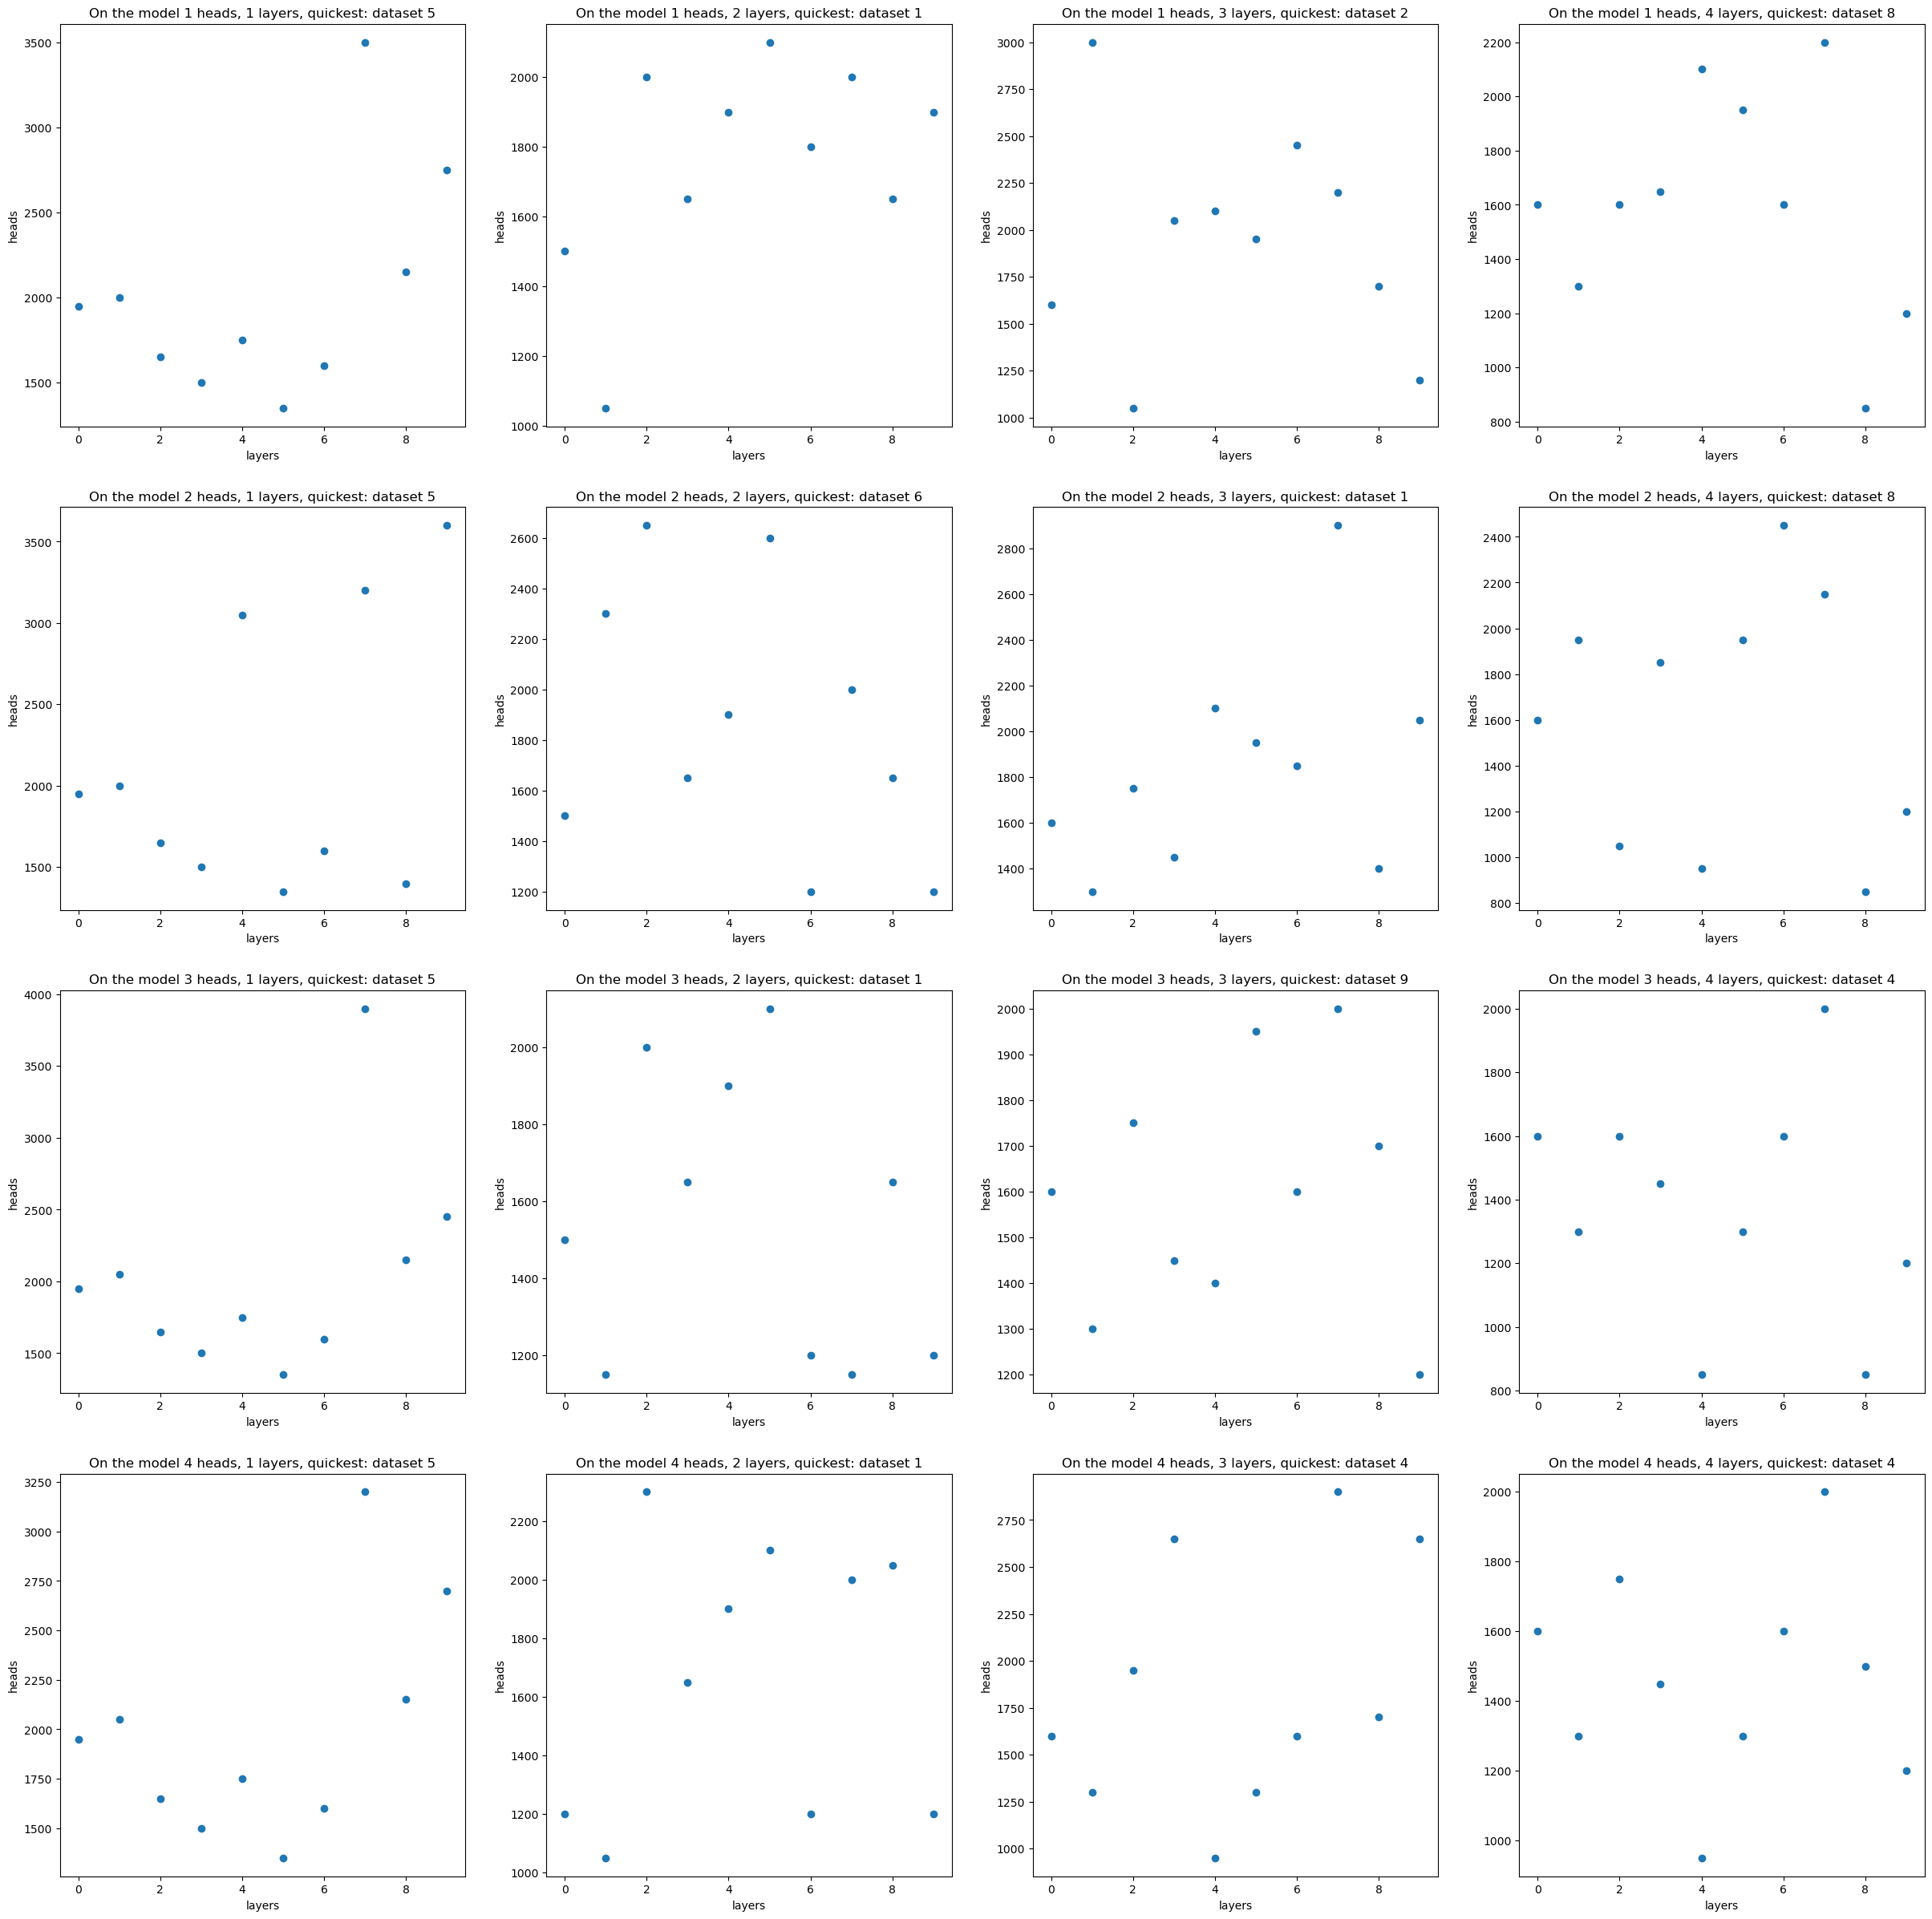

In [136]:
fig, axes = plt.subplots(4,4)
fig.set_figheight(30)
fig.set_figwidth(30)
lst = []
# ticks = [1,2,3,4]
for i in range(16):
    ax = axes[i//4, i%4]
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    mat_speed = df_speed[i//4, i%4,:]
    # j,k = np.unravel_index(mat_speed.argmin(),shape=(4,4))
    j = mat_speed.argmin()
    ax.set_title(f"On the model {i//4+1} heads, {i%4+1} layers, quickest: dataset {j}")
    ax.scatter(np.arange(10),mat_speed)
    lst.append(j)
    # c = ax.pcolor(ticks, ticks, mat_speed, cmap='viridis', vmin=np.min(df_speed), vmax=np.max(df_speed))
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(c, ax=ax)
# fig.colorbar(c, cax=cbar_ax)

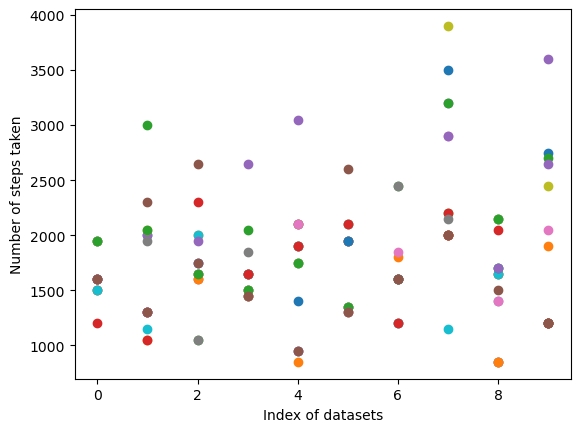

In [137]:
for i in range(16):
    mat_speed = df_speed[i//4, i%4,:]
    plt.scatter(np.arange(10),mat_speed, label=f"{i//4}heads,{i%4}layers")
plt.ylabel("Number of steps taken")
plt.xlabel("Index of datasets")
plt.show()

## Inspect more logs

In [138]:
log_ext = pd.read_csv("log.csv")
log_ext.columns

Index(['n_head', 'n_layer', 'rand_ind', 'best_metric', 'best_model_checkpoint',
       'total_steps'],
      dtype='object')

In [139]:
# create array for hyperparameter search that stores best result for each model
df_hs = np.zeros((6,6,10)) 
def transform_index(i,j,k):
    if i < 4:
        n_head = i+1
    elif i == 4:
        n_head = 6
    elif i == 5:
        n_head = 8
    return (n_head, j+1, k)
for i in range(6):
    for j in range(6):
        for k in range(10):
            n_head, n_layer, rand_ind = transform_index(i,j,k)
            rslt = log_df[(log_df['n_head'] == n_head) &
            (log_df['n_layer'] == n_layer) & (log_df['rand_ind'] == k)]
            df_hs[i,j,k] = rslt.iloc[0,3]
# get average of each set of hyperparameters over different ways of splitting datasets
mat_hs = np.mean(df_hs, axis=2)

In [140]:
# compute average of model performance over different splits of datasets
count_dic = {}
metric_dic = {}
for i in range(6):
    for j in range(6):
        key = transform_index(i,j, 0)
        metric_dic[key[:-1]] = mat_hs[i,j]

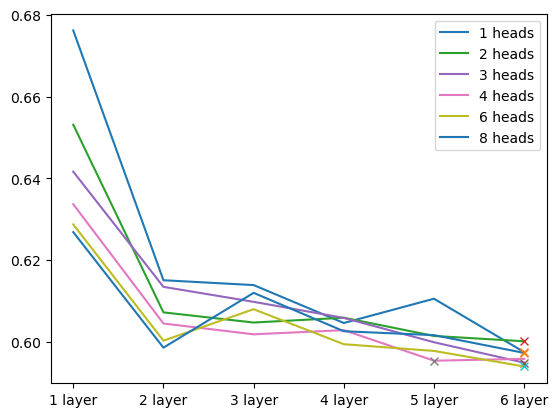

In [141]:
plot_by_head(metric_dic) # TODO reset colormap

In [142]:
def plot_by_head(dic):
    # use layer as x axis
    # input a dictionary of the form {(i,j):best_metric}
    # head_list = []
    # for i,key in enumerate(dic):
    #     head_list.append(key[0])
    # head_set = set(head_list)
    array_dic = {}
    for i,key in enumerate(dic):
        head = key[0]
        [x_array, y_array] = array_dic.get(head,[[],[]])
        x_array.append(key[1])
        y_array.append(dic[key])
        array_dic[head] = [x_array,y_array]
    for i,key in enumerate(array_dic):
        [x_array, y_array] = array_dic[key]
        x_array = np.array(x_array)
        y_array = np.array(y_array)
        sorted_indices = np.argsort(x_array)
        x_sorted = x_array[sorted_indices]
        y_sorted = y_array[sorted_indices]
        lowest_ind = np.argmin(y_sorted)
        lowest_x, lowest_y = x_sorted[lowest_ind], y_sorted[lowest_ind]
        plt.plot(x_sorted, y_sorted, label=f"{key} heads")
        plt.plot(lowest_x,lowest_y,"x")
    x = ["1 layer", "2 layer", "3 layer", "4 layer", "5 layer", "6 layer"]
    xi = list(range(1,len(x)+1))
    plt.xticks(xi,x)
    plt.legend()
    plt.show()


In [143]:
df_hs_ext.columns

NameError: name 'df_hs_ext' is not defined

In [ ]:
plot_df,_,_,_ = read_log("test/checkpoint-58900/trainer_state.json")

Text(0.5, 1.0, 'Loss against steps')

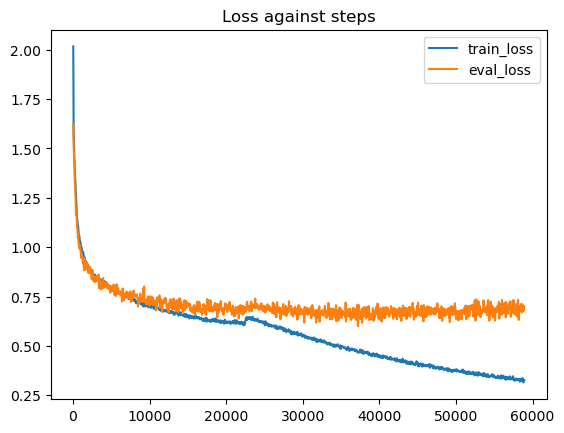

In [ ]:
plt.plot(plot_df["step"], plot_df["loss"], label="train_loss")
plt.plot(plot_df["step"], plot_df["eval_loss"], label="eval_loss")
plt.legend()
plt.title("Loss against steps")

## Collate prediction outputs

In [ ]:
# Initialise the tokeniser
tokenizer = RobertaTokenizer.from_pretrained("antibody-tokenizer")

# Initialise the data collator, which is necessary for batching
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
# specify the model used

model = RobertaForMaskedLM.from_pretrained("./backup_model/02-01-00")

In [ ]:
def load_FASTA(filename):
    count = 0
    current_seq = ''
    all_seqs = []
    with open(filename,'r') as f:
        for line in f:
            if line[0] == '>':
                all_seqs.append(current_seq)
                current_seq = ''
            else:
                current_seq+=line[:-1]
                count+=1
        all_seqs.append(current_seq)
        #all_seqs=np.array(map(lambda x: [aadict[y] for y in x],all_seqs[1:]),dtype=int,order="c")
    return all_seqs    

# I aligned and prepared a set of ~3000 antibodies from SabDab
name_fasta='input/sabdab_heavy.txt'
seqs_al  =load_FASTA(name_fasta)[1:]
   
seqs=[]
for s in range(len(seqs_al)):
    seqs.append(''.join([seqs_al[s][i] for i in range(len(seqs_al[s])) if seqs_al[s][i]!='-']))

In [ ]:
rand_ind = 0
random_seed = rand_ind + 2023
# recover test datasets
split_ratio = [0.8,0.1,0.1]
def write2file(st, name):
    with open(f"./assets_{rand_ind}/"+name+'.txt', 'w') as f:
        for line in st:
            f.write(line+"\n")
print("spliting")
N = len(seqs)
np.random.seed(random_seed)
split_indices = np.random.permutation(N)
train_indices = split_indices[:int(N*split_ratio[0])]
# print(train_indices)
val_indices = split_indices[int(N*split_ratio[0]):int(N*((split_ratio[0])+split_ratio[1]))]
test_indices = split_indices[int(N*((split_ratio[0])+split_ratio[1])):]
seqs = np.array(seqs)
train_seqs = seqs[train_indices]
val_seqs = seqs[val_indices]
test_seqs = seqs[test_indices]
write2file(train_seqs, "train_small")
write2file(val_seqs, "val_small")
write2file(test_seqs, "test_small")

spliting


In [ ]:
text_datasets = {
    "train": [f'assets_{rand_ind}/train_small.txt'],
    "eval": [f'assets_{rand_ind}/val_small.txt'],
    "test": [f'assets_{rand_ind}/test_small.txt']
}

dataset = load_dataset("text", data_files=text_datasets)

tokenized_dataset = dataset.map(
    lambda z: tokenizer(
        z["text"],
        padding="max_length",
        truncation=True,
        max_length=150,
        return_special_tokens_mask=True,
    ),
    batched=True,
    num_proc=1,
    remove_columns=["text"],
)

Using custom data configuration default-2302470aa45de876


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Parameter 'function'=<function <lambda> at 0x000001DF88E78940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Dataset text downloaded and prepared to C:\Users\XTM23\.cache\huggingface\datasets\text\default-2302470aa45de876\0.0.0\e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
trainer = Trainer(
    model=model,
    # args=args,
    data_collator=collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["eval"] # TODO inject tokenizer in trainer
)
output = trainer.predict(tokenized_dataset["test"])
test_loss = output[2]["test_loss"]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
output[0][0].shape # TODO, why padding increases to 150?

(315, 150, 25)

In [ ]:
# TODO first move models to one directory, and rename accordingly
def prediction(model):
    # input (n_head, n_layer, rand_ind)
    # return prediction output
def test_loss(model):
    # input (n_head, n_layer, rand_ind)
    # output a csv row, with columns: n_head, n_layer, rand_ind, test_loss
    # besides, save prediction output for future use

In [ ]:
# TODO: run this cell to get probability, a simpler method?
probs = []
for s in range(N):
#for s in range(1,2):
    # for a given seq, convert each symbol to a number (position along the alphabet)
    # and add a begind/end symbol
    # token_ids = tokenizer.encode(seqs[s], return_tensors='pt')
    token_ids = tokenizer.encode(seqs_al[s], return_tensors='pt') # to maintain a homogeneous shape
    #train
    # take the model and calculate the MaskedLMOutput, take its logits
    # which are in a matrix with size # tokens x # symbols 
    ## (note: it's a single-sequence embedding)
    out = model(token_ids)
    mat = out['logits'].squeeze()
    
    ## calculate attention of each token, which is a probability conditional on the rest of the sequence
    ## to obtain a probability, one normalizes over the column (possible symbols at that position)
    ## and flatten everything into a vector of length # tokens x # symbols
    prob = torch.nn.functional.softmax(mat, dim=1).detach().numpy()
    probs.append(prob)
    # add progress indicator
    if s%10 == 0:
        print(f"{(s+1)/N} done")

0.0003178639542275906 done
0.0034965034965034965 done
0.006675143038779402 done
0.009853782581055308 done
0.013032422123331213 done
0.01621106166560712 done
0.019389701207883026 done
0.02256834075015893 done
0.02574698029243484 done
0.028925619834710745 done
0.032104259376986646 done
0.035282898919262555 done
0.038461538461538464 done
0.041640178003814365 done
0.044818817546090274 done
0.04799745708836618 done
0.051176096630642084 done
0.05435473617291799 done
0.057533375715193895 done
0.060712015257469804 done
0.0638906547997457 done
0.06706929434202162 done
0.07024793388429752 done
0.07342657342657342 done
0.07660521296884933 done
0.07978385251112524 done
0.08296249205340114 done
0.08614113159567705 done
0.08931977113795296 done
0.09249841068022886 done
0.09567705022250476 done
0.09885568976478068 done
0.10203432930705658 done
0.10521296884933248 done
0.10839160839160839 done
0.1115702479338843 done
0.1147488874761602 done
0.1179275270184361 done
0.12110616656071202 done
0.1242848061

In [ ]:
np.shape(probs[4])

(130, 25)

In [ ]:
entropies_t=[]
entropies_p=[]
mapping_indices_seq=[]
for s in range(len(final_indices)):
    token_ids = tokenizer.encode(seqs[final_indices[s]], return_tensors='pt')

    seq1 = seqs[final_indices[s]]
    seq2 = seqs_al[final_indices_al[s]]

    #print(seq1)
    #print(seq2)

    indices_al = [] # collate indices of symbols on aligned seq that are not gap
    i = 0
    j = 0
    while i < len(seq1) and j < len(seq2): # double pointers
        if seq1[i] == seq2[j]:
            indices_al.append(j)
            i += 1
        j += 1
        
    
    ## Check consistent def of indices ##
    list1=[]
    list2=[]
    for i in range(len(seqs[final_indices[s]])):
        list1.append(seqs[final_indices[s]][i])
        #print(indices_al[i])
        ip = indices_al[i]
        list2.append(seqs_al[final_indices_al[s]][ip])
    #plt.scatter(list1,list2), should be  y=x

    
    ## single-sequence, single-site entropy ##
    ent_t = [] 
    ent_p = [] 
    c=0
    uu=[]
    for i in range(1,len(token_ids.squeeze())-1): # I don't consider end and start of the sequence added by the embedding
        ## position ##
        a = int(token_ids.squeeze()[i])
        uu.append(a)
        ## HERE: possible I need to exclude from entropy 
        ## computation the unphysical variables, like mask, pad, start/end etc
        ent_t.append(sum(-(probs[s][i][:])*np.log2(probs[s][i][:]+1/Mb)))
        ip = indices_al[c]
        #mapping_indices.append(ip)
        c+=1
        #sym = seqs_al[final_indices_al[s]][ip]
        #a = vocab[sym]
        ## here too I might need to exclude the unphysical symbols, 
        ## but they have zero frequency in any case, just I need to 
        ## re-do the normalization over the new set of symbols!!
        ent_p.append(sum(-pwm[ip,pwm[ip,:]>0]*np.log2(pwm[ip,pwm[ip,:]>0])))

    ## check consistency ##
    str1=''
    str2 = str1.join([vocab_inv[u] for u in uu])
    #print(seq1==str2)
    
    entropies_t.append(ent_t)
    entropies_p.append(ent_p)
    mapping_indices_seq.append(indices_al)
    

In [ ]:
pwm[0,pwm[0,:]>0]

array([6.6751428e-02, 8.5823266e-03, 9.5359184e-04, 1.6528925e-02,
       3.6236492e-01, 1.5893198e-03, 2.2250477e-03, 2.8607757e-03,
       1.2714558e-03, 1.5893198e-03, 1.2714558e-03, 6.3572789e-04,
       5.2638268e-01, 3.1786396e-03, 1.9071837e-03, 3.1786395e-04,
       1.5893198e-03], dtype=float32)

In [ ]:
ref=19 # TODO try more different sequences
vec1=np.array(entropies_p[ref])
vec2=np.array(entropies_t[ref])

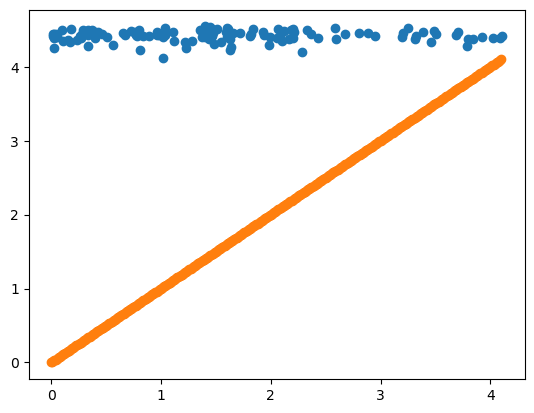

In [ ]:
plt.scatter(vec1,vec2)
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))

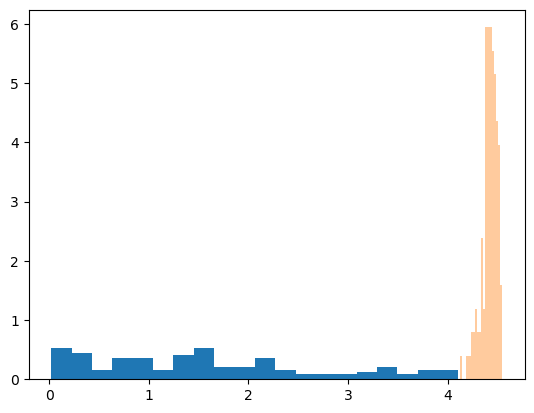

In [ ]:
plt.hist(vec1, density=True, bins=20); #CIE
plt.hist(vec2,alpha=0.4, density=True, bins=20); #CDE

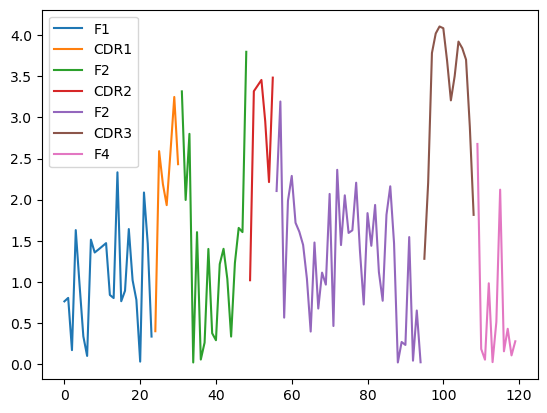

In [ ]:
b_cdr1n = mapping_indices_seq[ref].index(b_cdr1) # complementary determining matrix
e_cdr1n = mapping_indices_seq[ref].index(e_cdr1)
b_cdr2n = mapping_indices_seq[ref].index(b_cdr2)
e_cdr2n = mapping_indices_seq[ref].index(e_cdr2)
b_cdr3n = mapping_indices_seq[ref].index(b_cdr3)
e_cdr3n = mapping_indices_seq[ref].index(e_cdr3)


import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1n), vec1[:b_cdr1n], label='F1')
plt.plot(np.arange(b_cdr1n,e_cdr1n), vec1[b_cdr1n:e_cdr1n], label='CDR1')
plt.plot(np.arange(e_cdr1n, b_cdr2n), vec1[e_cdr1n: b_cdr2n], label='F2')
plt.plot(np.arange(b_cdr2n, e_cdr2n), vec1[b_cdr2n:e_cdr2n], label='CDR2')
plt.plot(np.arange(e_cdr2n, b_cdr3n), vec1[e_cdr2n: b_cdr3n], label='F2')
plt.plot(np.arange(b_cdr3n,e_cdr3n), vec1[b_cdr3n:e_cdr3n], label='CDR3')
plt.plot(np.arange(e_cdr3n, len(seqs[ref])), vec1[e_cdr3n:], label='F4')
plt.legend()

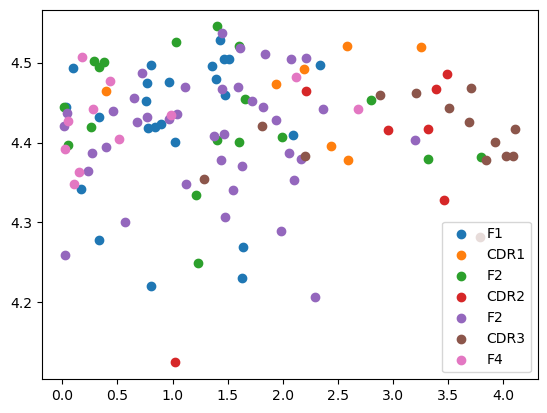

In [ ]:
plt.scatter(vec1[:b_cdr1n], vec2[:b_cdr1n], label='F1')
plt.scatter(vec1[b_cdr1n:e_cdr1n], vec2[b_cdr1n:e_cdr1n], label='CDR1')
plt.scatter(vec1[e_cdr1n: b_cdr2n], vec2[e_cdr1n: b_cdr2n], label='F2')
plt.scatter(vec1[b_cdr2n:e_cdr2n], vec2[b_cdr2n:e_cdr2n], label='CDR2')
plt.scatter(vec1[e_cdr2n: b_cdr3n], vec2[e_cdr2n: b_cdr3n], label='F2')
plt.scatter(vec1[b_cdr3n:e_cdr3n], vec2[b_cdr3n:e_cdr3n], label='CDR3')
plt.scatter(vec1[e_cdr3n:], vec2[e_cdr3n:], label='F4')
plt.legend()

In [ ]:
## Finally, for each position, summing over possible symbols
## in a way which is conditional or unconditional on the rest of the sequence
## we get the CDE and the CIE
cie=[]
cde=[]
for i in range(NA): ## for each position, we sum over the sequences that have that position ##
    relevant_seq = [s for s in range(len(entropies_p)) if i in mapping_indices_seq[s]]
    if len(relevant_seq)>0:
        ep=0
        et=0
        for s in relevant_seq:
            j = mapping_indices_seq[s].index(i)
            ep+=entropies_p[s][j]
            et+=entropies_t[s][j]
        cie.append(ep/len(relevant_seq))
        cde.append(et/len(relevant_seq))
    else:
        cie.append(0)
        cde.append(0)

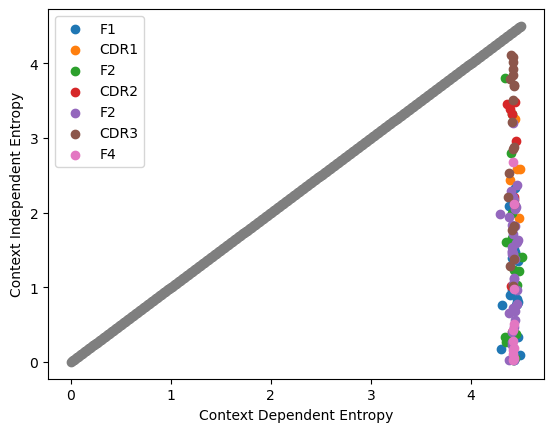

In [ ]:
vec1=list(cde)
vec2=list(cie)

plt.scatter(vec1[:b_cdr1], vec2[:b_cdr1], label='F1')
plt.scatter(vec1[b_cdr1:e_cdr1], vec2[b_cdr1:e_cdr1], label='CDR1')
plt.scatter(vec1[e_cdr1: b_cdr2], vec2[e_cdr1: b_cdr2], label='F2')
plt.scatter(vec1[b_cdr2:e_cdr2], vec2[b_cdr2:e_cdr2], label='CDR2')
plt.scatter(vec1[e_cdr2: b_cdr3], vec2[e_cdr2: b_cdr3], label='F2')
plt.scatter(vec1[b_cdr3:e_cdr3], vec2[b_cdr3:e_cdr3], label='CDR3')
plt.scatter(vec1[e_cdr3:], vec2[e_cdr3:], label='F4')
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))
plt.ylabel("Context Independent Entropy")
plt.xlabel("Context Dependent Entropy")
plt.legend()

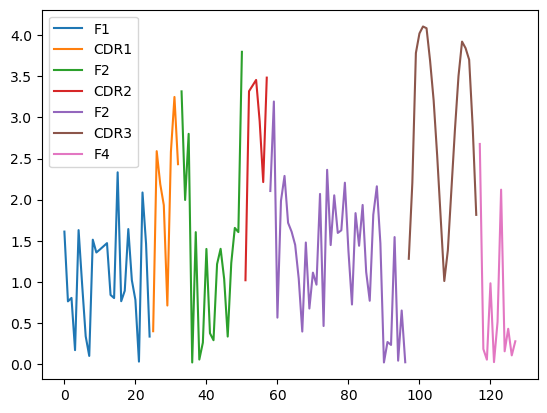

In [ ]:
ent_p_al = np.array(cie)
import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1), ent_p_al[:b_cdr1], label='F1')
plt.plot(np.arange(b_cdr1,e_cdr1), ent_p_al[b_cdr1:e_cdr1], label='CDR1')
plt.plot(np.arange(e_cdr1, b_cdr2), ent_p_al[e_cdr1: b_cdr2], label='F2')
plt.plot(np.arange(b_cdr2,e_cdr2), ent_p_al[b_cdr2:e_cdr2], label='CDR2')
plt.plot(np.arange(e_cdr2, b_cdr3), ent_p_al[e_cdr2: b_cdr3], label='F2')
plt.plot(np.arange(b_cdr3,e_cdr3), ent_p_al[b_cdr3:e_cdr3], label='CDR3')
plt.plot(np.arange(e_cdr3, NA), ent_p_al[e_cdr3:], label='F4')
plt.legend()

In [ ]:
# rewrite a loss function
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = tokenizer.encode(inputs, return_tensors="pt") # get token id for input sequence
#         # forward pass
#         outputs = model(**inputs)
#         token_ids = tokenizer.encode(seqs[s], return_tensors='pt')
#     #train
#     # take the model and calculate the MaskedLMOutput, take its logits
#     # which are in a matrix with size # tokens x # symbols 
#     ## (note: it's a single-sequence embedding)
#     out = trainer.model(token_ids)
#         logits = outputs.get("logits")
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0], device=model.device))
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         # loss = nn.CrossEntropyLoss()
#         return (loss, outputs) if return_outputs else loss

## Direct Coupling Analysis

<https://github.com/KIT-MBS/pydca/tree/master>

In [ ]:
def slice_couplings(couplings = None, site_pair=None, num_site_states=None, seqs_len = None):
    """Constructs couplings array suitable for computing two-site-model fields as well 
    as DI scores. 

    Parameters
    ----------
        couplings : np.array
            A 1 array of couplings excluding gap state couplings
        site_pair : tuple
            Site pair (i, j) such that j > i with o <= i < seqs_len
        num_site_states : int 
            Number of site states for sequence 
        seqs_len : int 
            Length of sequences in MSA data 
    """
    i, j = site_pair[0], site_pair[1]
    q = num_site_states
    qm1 = q - 1
    pair_loc = int((seqs_len * (seqs_len - 1)/2) - (seqs_len - i) * ((seqs_len - i) - 1)/2  + j  - i - 1)
    start_indx = pair_loc * qm1 * qm1  
    end_indx = start_indx + qm1 * qm1
    couplings_ij = np.zeros((q, q), dtype = np.float64)
    couplings_tmp = couplings[start_indx:end_indx]
    couplings_ij[:q-1, :q-1]  = np.reshape(couplings_tmp, shape = (q-1, q-1))
    return couplings_ij 

## Interpret results (duplicate)

In [ ]:
# slight discrepancy in naming
# train-i-j-k -> {n_head}-{n_layer}-{rand_ind}
# model name: n_layer, n_head,rand_ind

In [ ]:
# transform json files into dataframe

def read_log(filepath):
    js = pd.read_json(filepath)
    s = js["best_model_checkpoint"][0] # the directory of best checkpoint
    best_model_checkpoint = int(s.split("-")[-1]) # the number of steps at which the best metric is obtained
    lst = filepath.split("checkpoint-")
    lst = lst[1].split("/")
    total_steps = int(lst[0])
    df = pd.json_normalize(js["log_history"])
    n = len(df)
    # dataframe contianing eval loss
    odd_indx = np.array([i for i in range(n) if i%2 == 1])
    df1 = df.loc[odd_indx,:]
    # dataframe contianing train loss
    even_indx = np.array([i for i in range(n) if i%2 == 0])
    df2 = df.loc[even_indx,:]

    df1 = df1[["step", "eval_loss"]]
    df2 = df2[["step", "loss"]]
    df3 = df1.join(df2.set_index('step'), on='step')
    return df3,js["best_metric"][0],best_model_checkpoint, total_steps

In [ ]:
path = generate_path(1,2,0)
plot_df, best_metric,best_model_checkpoint,total_steps = read_log(path)

In [ ]:
unfinished_2 = []
finished2 = []
for i in range(1,5):
    for j in range(1,5):
        for k in range(10):
            try:
                _, _,best_model_checkpoint,total_steps = read_log(generate_path(i,j,k))
                if total_steps < best_model_checkpoint + 500:
                    print((i,j,k))
                    unfinished_2.append((i,j,k))
            except FileNotFoundError:
                print("insided finished 02")
                finished2.append((i,j,k))

insided finished 02
insided finished 02
insided finished 02
(1, 2, 0)
insided finished 02
(1, 2, 8)
insided finished 02
(1, 3, 1)
insided finished 02
(1, 3, 9)
(1, 4, 0)
(1, 4, 4)
insided finished 02
(1, 4, 8)
insided finished 02
insided finished 02
(2, 2, 0)
insided finished 02
insided finished 02
(2, 2, 7)
(2, 2, 8)
(2, 2, 9)
insided finished 02
insided finished 02
insided finished 02
(2, 4, 0)
insided finished 02
insided finished 02
insided finished 02
(2, 4, 8)
insided finished 02
(3, 2, 0)
insided finished 02
insided finished 02
(3, 3, 4)
insided finished 02
insided finished 02
(3, 4, 4)
insided finished 02
insided finished 02
insided finished 02
(4, 2, 0)
(4, 2, 2)
(4, 2, 4)
insided finished 02
(4, 2, 7)
insided finished 02
(4, 2, 9)
insided finished 02
insided finished 02
insided finished 02
(4, 4, 0)
(4, 4, 4)
insided finished 02


In [ ]:
def list2txt(lst,filepath):
    """
    save content of a list into text file
    Args:
        lst: a list of tuples
        filepath: a string indicating the path of a text file
    """
    # clear file content before writing
    if os.path.isfile(filepath):
        open(filepath, 'w').close()
    with open(filepath, 'w') as f:
        for line in lst:
            f.write(str(line)+"\n")

In [ ]:
list2txt(unfinished_2,"round_11.txt")

In [ ]:
for m in range(len(unfinished_2)):
    i,j,k = unfinished_2[m]
    s = "-".join(["train",str(i),str(j),str(k)])
    train_path = "finished/"+s
    new_train_path = f"./train-11-{m+1}"
    os.rename(train_path, new_train_path)

In [ ]:
for m in range(len(unfinished_2)):
    i,j,k = unfinished_2[m]
    modelname = os.listdir(f"./train-11-{m+1}/model")[0]
    print(modelname)
    train_path = f"./train-11-{m+1}/model/"+modelname
    new_train_path = f"./backup_model/{modelname}"
    os.rename(train_path, new_train_path)

02-01-00
02-01-08
03-01-01
03-01-09
04-01-00
04-01-04
04-01-08
02-02-00
02-02-07
02-02-08
02-02-09
04-02-00
04-02-08
02-03-00
03-03-04
04-03-04
02-04-00
02-04-02
02-04-04
02-04-07
02-04-09
04-04-00
04-04-04


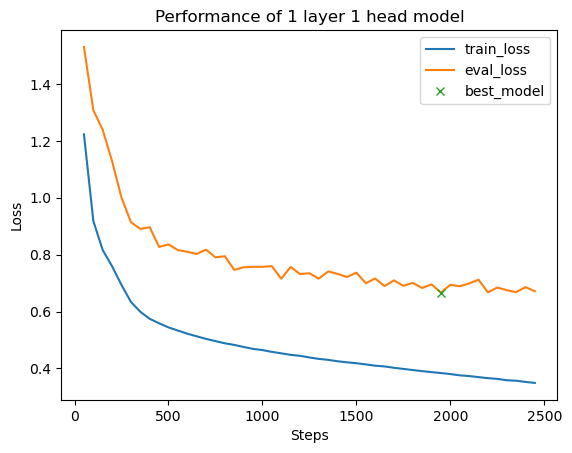

In [ ]:
plt.plot(plot_df[["step"]], plot_df[["loss", "eval_loss"]], label=["train_loss","eval_loss"])
plt.plot(best_model_checkpoint,best_metric,"x", label="best_model") # Note each eval is not evenly spread over steps
plt.title("Performance of 1 layer 1 head model")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def training_report():
    train_finished = []
    continue_training = []
    for i in range(1,5):
    # i is the number of heads
        for j in range(1,5):
            #j is the number of layers
            for k in range(2):
                # k is the index of split datasets
                if (i-1)*8+(j-1)*2+k+1 not in [1,2,7,17,19,25]:
                    jspath = generate_path(i,j,k+1)
                    plot_df, best_metric, best_model_checkpoint,total_steps = read_log(jspath)
                    eval_loss = np.array(plot_df[["eval_loss"]])
                    if earlystop_detection(eval_loss):
                        print(f"{i} heads {j} layers model {k} early stopped at {best_metric}")
                        train_finished.append((i,j,k))
                    else:
                        print(best_model_checkpoint,total_steps)
                        print(f"{i} heads {j} layers model {k} more training required")
                        continue_training.append((i,j,k))

    return train_finished,continue_training

In [ ]:
jspath = generate_path(1,3,2)
plot_df, best_metric, best_model_checkpoint, total_steps = read_log(jspath)
lst = jspath.split("checkpoint-")
lst = lst[1].split("/")
total_steps = int(lst[0])

## Compare with RBM

In [ ]:
model = RobertaForMaskedLM.from_pretrained("model-4-6-1")
probs= extract_prob(model)

0.0003178639542275906 done
0.032104259376986646 done
0.0638906547997457 done
0.09567705022250476 done
0.12746344564526382 done
0.1592498410680229 done
0.19103623649078194 done
0.222822631913541 done
0.2546090273363001 done
0.2863954227590591 done
0.3181818181818182 done
0.34996821360457725 done
0.3817546090273363 done
0.41354100445009534 done
0.4453273998728544 done
0.4771137952956135 done
0.5089001907183726 done
0.5406865861411316 done
0.5724729815638907 done
0.6042593769866497 done
0.6360457724094087 done
0.6678321678321678 done
0.6996185632549269 done
0.731404958677686 done
0.763191354100445 done
0.7949777495232041 done
0.8267641449459632 done
0.8585505403687221 done
0.8903369357914812 done
0.9221233312142403 done
0.9539097266369994 done
0.9856961220597584 done


In [ ]:
# Open the file in binary mode
import pickle
with open('output/prob.pkl', 'rb') as file:
      
    # Call load method to deserialze
    probs_rbm = pickle.load(file)

# with open("output/output-4-6-1.pkl", "rb") as file:
#     probs_mlm = pickle.load(file)

In [ ]:
np.array(probs_rbm).shape

(3146, 128, 21)

In [ ]:
voab_mlm = {{
  "<s>": 0,
  "</s>": 2,
  "<pad>": 1,
  "<unk>": 3,
  "<mask>": 4,
  "A": 5,
  "C": 6,
  "D": 7,
  "E": 8,
  "F": 9,
  "G": 10,
  "H": 11,
  "I": 12,
  "K": 13,
  "L": 14,
  "M": 15,
  "N": 16,
  "P": 17,
  "Q": 18,
  "R": 19,
  "S": 20,
  "T": 21,
  "V": 22,
  "W": 23,
  "Y": 24
}}

In [ ]:
vocab_rbm = {'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19,
 '-': 20}

In [ ]:
probs_rbm = np.array(probs_rbm)[:,:,:-1]

In [ ]:
probs_mlm = np.array(probs)
probs_mlm = probs_mlm[:,1:-1,5:]
probs_rbm = np.array(probs_rbm)[:,:,:-1]

In [ ]:
probs_rbm.shape

(3146, 128, 20)

In [ ]:
ref  = 40
diff = probs_mlm[ref]-probs_rbm[ref]

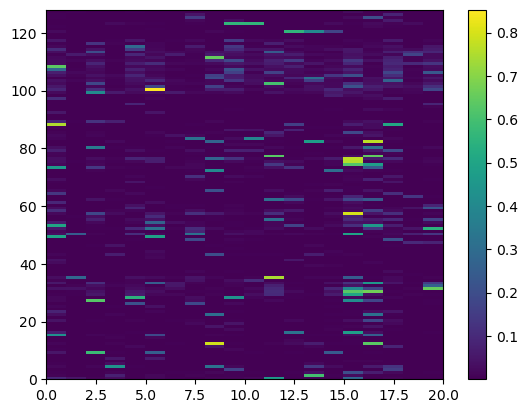

In [ ]:
heatmap = plt.pcolor(np.abs(diff)) 
plt.colorbar(heatmap)

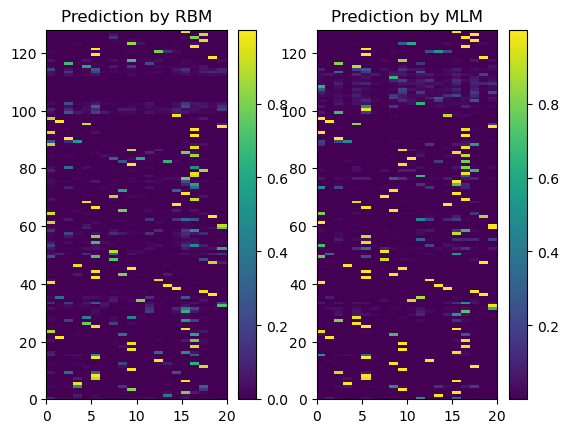

In [ ]:
fig, axes = plt.subplots(1,2)
for i in range(2):
    ax = axes[i]
    if i == 0:
        heatmap = ax.pcolor(probs_rbm[ref]) 
        plt.colorbar(heatmap)
        ax.set_title("Prediction by RBM")
    else:
        heatmap = plt.pcolor(probs_mlm[ref]) 
        plt.colorbar(heatmap)
        ax.set_title("Prediction by MLM")


### Check specific sites(duplicate)

In [ ]:
def prob_at_site(index, probs=probs_mlm):
    # index: integer, position at aligned sequences
    # return: an array of n_seqx25
    n_seq = len(probs)
    output = np.zeros((n_seq,20))
    for i in range(n_seq):
        output[i,:] = probs_mlm[i][index,:]
    return output

(array([3.290e+02, 0.000e+00, 7.600e+01, 0.000e+00, 0.000e+00, 4.400e+01,
        2.000e+00, 1.120e+02, 1.000e+00, 0.000e+00, 6.200e+01, 1.300e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 4.300e+01,
        2.700e+01, 2.435e+03]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. ]),
 <BarContainer object of 20 artists>)

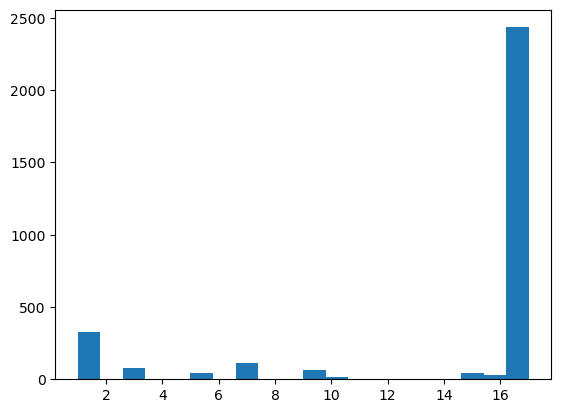

In [ ]:
output = prob_at_site(97)
output = np.argmax(output, axis=1)
plt.hist(output, bins=20)

## Extract attentions

In [ ]:
model = RobertaForMaskedLM.from_pretrained("./model-4-6-1")
# Fix n_layers
# Fix n_heads TODO
# TODO fix a special sequence
# TODO quantative patterns, check against specific sites

In [ ]:
# TODO save this result to file
attentions_list = []
for i in range(len(seqs_al)):
    token_ids = tokenizer.encode(seqs_al[0], return_tensors='pt')
    out = model(token_ids)
    # attentions = out.attentions[0][0][0] # 130x130 array
    attentions_list.append(out.attentions)
    print(i)

In [ ]:
ref = 9
token_ids = tokenizer.encode(seqs_al[ref], return_tensors="pt")
out = model(token_ids)
mat = out.attentions[0][0]
mat = mat.detach().numpy()

In [ ]:
N = len(seqs_al)
mat_all = np.zeros((N, 4, 130, 130))
for i in range(N):
    token_ids = tokenizer.encode(seqs_al[i], return_tensors="pt")
    out = model(token_ids)
    mat = out.attentions[0][0]
    mat = mat.detach().numpy()
    mat_all[i,:,:,:] = mat
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

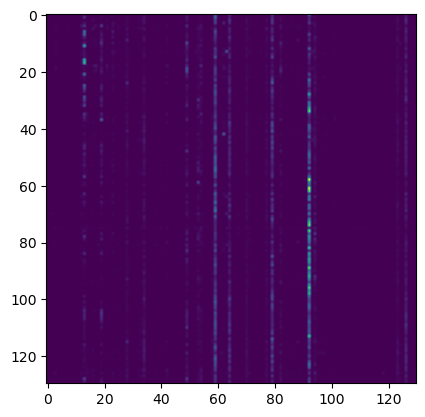

In [ ]:
plt.imshow(mat[0])

In [ ]:
attentions_list = np.array(attentions_list)

In [ ]:
mat = np.mean(attentions_list, axis=0)

In [ ]:
# mat = np.zeros((130,130))
# for i in range(130):
#     for j in range(130):
#         mean = 0
#         for s in range(len(seqs_al)):
#             mean += attentions_list[s][i,j]
#         mean = mean/len(seqs_al)
#         mat[i,j] = mean
#         print(i,j)

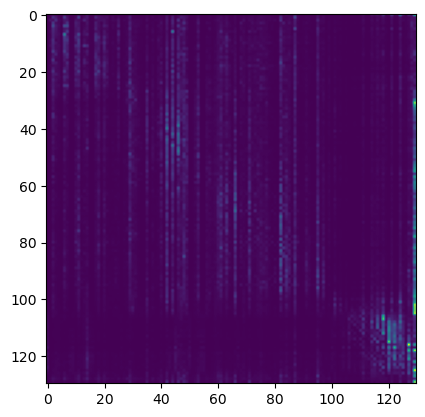

In [ ]:
plt.imshow(mat)

In [ ]:
ref = 12 # example VH 1
# ref=1584/1571 # example VH 2
# ref = 370 # PDB: 7KFX